# Advanced Sampling Techniques: SMOTE & Variants

## Objectives
1. Apply SMOTE (Synthetic Minority Over-sampling Technique)
2. Compare different sampling strategies:
   - SMOTE
   - ADASYN (Adaptive Synthetic Sampling)
   - BorderlineSMOTE
   - SMOTE + Tomek Links
3. Evaluate impact on model performance
4. Compare with baseline class weighting approach

## When to Use SMOTE
- Severe class imbalance (>10:1 ratio)
- Small minority class sample size
- When class weighting alone isn't sufficient

---

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
from collections import Counter

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Sampling techniques
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Set up paths
project_root = Path.cwd().parent
data_dir = project_root / 'data'
processed_data_dir = data_dir / 'processed'
models_dir = project_root / 'models'
figures_dir = project_root / 'figures'

print(f"Project root: {project_root}")

Project root: C:\Users\FR33STYLE\FeatureBeats


## 1. Load Data

In [3]:
# Load dataset
data_file = processed_data_dir / 'hits_dataset.csv'
df = pd.read_csv(data_file)

# Prepare features and target
exclude_cols = ['is_hit', 'year']
text_cols = df.select_dtypes(include=['object']).columns.tolist()
exclude_cols.extend(text_cols)
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].values
y = df['is_hit'].values

print(f"Dataset shape: {X.shape}")
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y)*100:.2f}%)")
print(f"\nImbalance ratio: {counts[0]/counts[1]:.1f}:1")

Dataset shape: (113999, 9)

Class distribution:
  Class 0: 111,861 (98.12%)
  Class 1: 2,138 (1.88%)

Imbalance ratio: 52.3:1


In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {len(X_train):,} samples")
print(f"Test set:  {len(X_test):,} samples")
print(f"\nTrain class distribution: {Counter(y_train)}")

Train set: 91,199 samples
Test set:  22,800 samples

Train class distribution: Counter({np.int64(0): 89489, np.int64(1): 1710})


## 2. Baseline (No Sampling)

First, let's establish a baseline using class weighting only.

In [5]:
# Train baseline model
print("Training baseline (class weighting only)...")

baseline_model = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_SEED,
    max_iter=1000
)
baseline_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred_baseline = baseline_model.predict(X_test_scaled)
y_pred_proba_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

baseline_metrics = {
    'Method': 'Baseline (Class Weighting)',
    'Train Samples': len(X_train),
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline),
    'Recall': recall_score(y_test, y_pred_baseline),
    'F1': f1_score(y_test, y_pred_baseline),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_baseline),
    'PR-AUC': average_precision_score(y_test, y_pred_proba_baseline)
}

print("\nBaseline Results:")
for metric, value in baseline_metrics.items():
    if isinstance(value, (int, float)) and metric != 'Train Samples':
        print(f"  {metric:12s}: {value:.4f}")
    else:
        print(f"  {metric:12s}: {value}")

Training baseline (class weighting only)...

Baseline Results:
  Method      : Baseline (Class Weighting)
  Train Samples: 91199
  Accuracy    : 0.6198
  Precision   : 0.0394
  Recall      : 0.8224
  F1          : 0.0751
  ROC-AUC     : 0.7688
  PR-AUC      : 0.0546


## 3. SMOTE (Synthetic Minority Over-sampling)

SMOTE creates synthetic samples by:
1. Finding k-nearest neighbors of minority class samples
2. Interpolating between samples and their neighbors
3. Creating new synthetic minority samples

In [6]:
# Apply SMOTE
print("Applying SMOTE...")

smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\nOriginal training set: {Counter(y_train)}")
print(f"After SMOTE:           {Counter(y_train_smote)}")
print(f"\nNew training set size: {len(X_train_smote):,} (increased by {len(X_train_smote) - len(X_train):,})")

Applying SMOTE...

Original training set: Counter({np.int64(0): 89489, np.int64(1): 1710})
After SMOTE:           Counter({np.int64(0): 89489, np.int64(1): 89489})

New training set size: 178,978 (increased by 87,779)


In [7]:
# Train model on SMOTE data
print("Training model with SMOTE...")

smote_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
smote_model.fit(X_train_smote, y_train_smote)

# Evaluate
y_pred_smote = smote_model.predict(X_test_scaled)
y_pred_proba_smote = smote_model.predict_proba(X_test_scaled)[:, 1]

smote_metrics = {
    'Method': 'SMOTE',
    'Train Samples': len(X_train_smote),
    'Accuracy': accuracy_score(y_test, y_pred_smote),
    'Precision': precision_score(y_test, y_pred_smote),
    'Recall': recall_score(y_test, y_pred_smote),
    'F1': f1_score(y_test, y_pred_smote),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_smote),
    'PR-AUC': average_precision_score(y_test, y_pred_proba_smote)
}

print("\nSMOTE Results:")
for metric, value in smote_metrics.items():
    if isinstance(value, (int, float)) and metric != 'Train Samples':
        print(f"  {metric:12s}: {value:.4f}")
    else:
        print(f"  {metric:12s}: {value}")

Training model with SMOTE...

SMOTE Results:
  Method      : SMOTE
  Train Samples: 178978
  Accuracy    : 0.6282
  Precision   : 0.0397
  Recall      : 0.8107
  F1          : 0.0757
  ROC-AUC     : 0.7690
  PR-AUC      : 0.0544


## 4. ADASYN (Adaptive Synthetic Sampling)

ADASYN is similar to SMOTE but generates more synthetic samples for minority class examples that are harder to learn.

In [8]:
# Apply ADASYN
print("Applying ADASYN...")

adasyn = ADASYN(random_state=RANDOM_SEED, n_neighbors=5)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

print(f"\nOriginal training set: {Counter(y_train)}")
print(f"After ADASYN:          {Counter(y_train_adasyn)}")

# Train model
adasyn_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
adasyn_model.fit(X_train_adasyn, y_train_adasyn)

# Evaluate
y_pred_adasyn = adasyn_model.predict(X_test_scaled)
y_pred_proba_adasyn = adasyn_model.predict_proba(X_test_scaled)[:, 1]

adasyn_metrics = {
    'Method': 'ADASYN',
    'Train Samples': len(X_train_adasyn),
    'Accuracy': accuracy_score(y_test, y_pred_adasyn),
    'Precision': precision_score(y_test, y_pred_adasyn),
    'Recall': recall_score(y_test, y_pred_adasyn),
    'F1': f1_score(y_test, y_pred_adasyn),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_adasyn),
    'PR-AUC': average_precision_score(y_test, y_pred_proba_adasyn)
}

print("\nADASYN Results:")
for metric, value in adasyn_metrics.items():
    if isinstance(value, (int, float)) and metric != 'Train Samples':
        print(f"  {metric:12s}: {value:.4f}")
    else:
        print(f"  {metric:12s}: {value}")

Applying ADASYN...

Original training set: Counter({np.int64(0): 89489, np.int64(1): 1710})
After ADASYN:          Counter({np.int64(1): 89751, np.int64(0): 89489})

ADASYN Results:
  Method      : ADASYN
  Train Samples: 179240
  Accuracy    : 0.6218
  Precision   : 0.0391
  Recall      : 0.8131
  F1          : 0.0747
  ROC-AUC     : 0.7700
  PR-AUC      : 0.0570


## 5. Borderline-SMOTE

Focuses on borderline samples (minority samples near the decision boundary) which are often more important.

In [9]:
# Apply Borderline-SMOTE
print("Applying Borderline-SMOTE...")

borderline_smote = BorderlineSMOTE(random_state=RANDOM_SEED, k_neighbors=5)
X_train_bsmote, y_train_bsmote = borderline_smote.fit_resample(X_train_scaled, y_train)

print(f"\nOriginal training set:    {Counter(y_train)}")
print(f"After Borderline-SMOTE:   {Counter(y_train_bsmote)}")

# Train model
bsmote_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
bsmote_model.fit(X_train_bsmote, y_train_bsmote)

# Evaluate
y_pred_bsmote = bsmote_model.predict(X_test_scaled)
y_pred_proba_bsmote = bsmote_model.predict_proba(X_test_scaled)[:, 1]

bsmote_metrics = {
    'Method': 'Borderline-SMOTE',
    'Train Samples': len(X_train_bsmote),
    'Accuracy': accuracy_score(y_test, y_pred_bsmote),
    'Precision': precision_score(y_test, y_pred_bsmote),
    'Recall': recall_score(y_test, y_pred_bsmote),
    'F1': f1_score(y_test, y_pred_bsmote),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_bsmote),
    'PR-AUC': average_precision_score(y_test, y_pred_proba_bsmote)
}

print("\nBorderline-SMOTE Results:")
for metric, value in bsmote_metrics.items():
    if isinstance(value, (int, float)) and metric != 'Train Samples':
        print(f"  {metric:12s}: {value:.4f}")
    else:
        print(f"  {metric:12s}: {value}")

Applying Borderline-SMOTE...

Original training set:    Counter({np.int64(0): 89489, np.int64(1): 1710})
After Borderline-SMOTE:   Counter({np.int64(0): 89489, np.int64(1): 89489})

Borderline-SMOTE Results:
  Method      : Borderline-SMOTE
  Train Samples: 178978
  Accuracy    : 0.6371
  Precision   : 0.0384
  Recall      : 0.7617
  F1          : 0.0730
  ROC-AUC     : 0.7676
  PR-AUC      : 0.0572


## 6. SMOTE + Tomek Links

Combines oversampling (SMOTE) with cleaning (removes Tomek links - pairs of opposite-class samples that are each other's nearest neighbors).

In [10]:
# Apply SMOTE + Tomek
print("Applying SMOTE + Tomek Links...")

smote_tomek = SMOTETomek(random_state=RANDOM_SEED)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train_scaled, y_train)

print(f"\nOriginal training set: {Counter(y_train)}")
print(f"After SMOTE+Tomek:     {Counter(y_train_st)}")

# Train model
st_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
st_model.fit(X_train_st, y_train_st)

# Evaluate
y_pred_st = st_model.predict(X_test_scaled)
y_pred_proba_st = st_model.predict_proba(X_test_scaled)[:, 1]

st_metrics = {
    'Method': 'SMOTE+Tomek',
    'Train Samples': len(X_train_st),
    'Accuracy': accuracy_score(y_test, y_pred_st),
    'Precision': precision_score(y_test, y_pred_st),
    'Recall': recall_score(y_test, y_pred_st),
    'F1': f1_score(y_test, y_pred_st),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_st),
    'PR-AUC': average_precision_score(y_test, y_pred_proba_st)
}

print("\nSMOTE+Tomek Results:")
for metric, value in st_metrics.items():
    if isinstance(value, (int, float)) and metric != 'Train Samples':
        print(f"  {metric:12s}: {value:.4f}")
    else:
        print(f"  {metric:12s}: {value}")

Applying SMOTE + Tomek Links...

Original training set: Counter({np.int64(0): 89489, np.int64(1): 1710})
After SMOTE+Tomek:     Counter({np.int64(0): 89489, np.int64(1): 89489})

SMOTE+Tomek Results:
  Method      : SMOTE+Tomek
  Train Samples: 178978
  Accuracy    : 0.6282
  Precision   : 0.0397
  Recall      : 0.8107
  F1          : 0.0757
  ROC-AUC     : 0.7690
  PR-AUC      : 0.0544


## 7. Comparison of All Methods

In [11]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    baseline_metrics,
    smote_metrics,
    adasyn_metrics,
    bsmote_metrics,
    st_metrics
])

print("\n" + "="*100)
print("SAMPLING METHODS COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("\n" + "="*100)


SAMPLING METHODS COMPARISON
                    Method  Train Samples  Accuracy  Precision   Recall       F1  ROC-AUC   PR-AUC
Baseline (Class Weighting)          91199  0.619781   0.039352 0.822430 0.075109 0.768790 0.054631
                     SMOTE         178978  0.628202   0.039689 0.810748 0.075673 0.769009 0.054416
                    ADASYN         179240  0.621798   0.039141 0.813084 0.074686 0.770042 0.057044
          Borderline-SMOTE         178978  0.637061   0.038357 0.761682 0.073037 0.767612 0.057239
               SMOTE+Tomek         178978  0.628202   0.039689 0.810748 0.075673 0.769009 0.054416



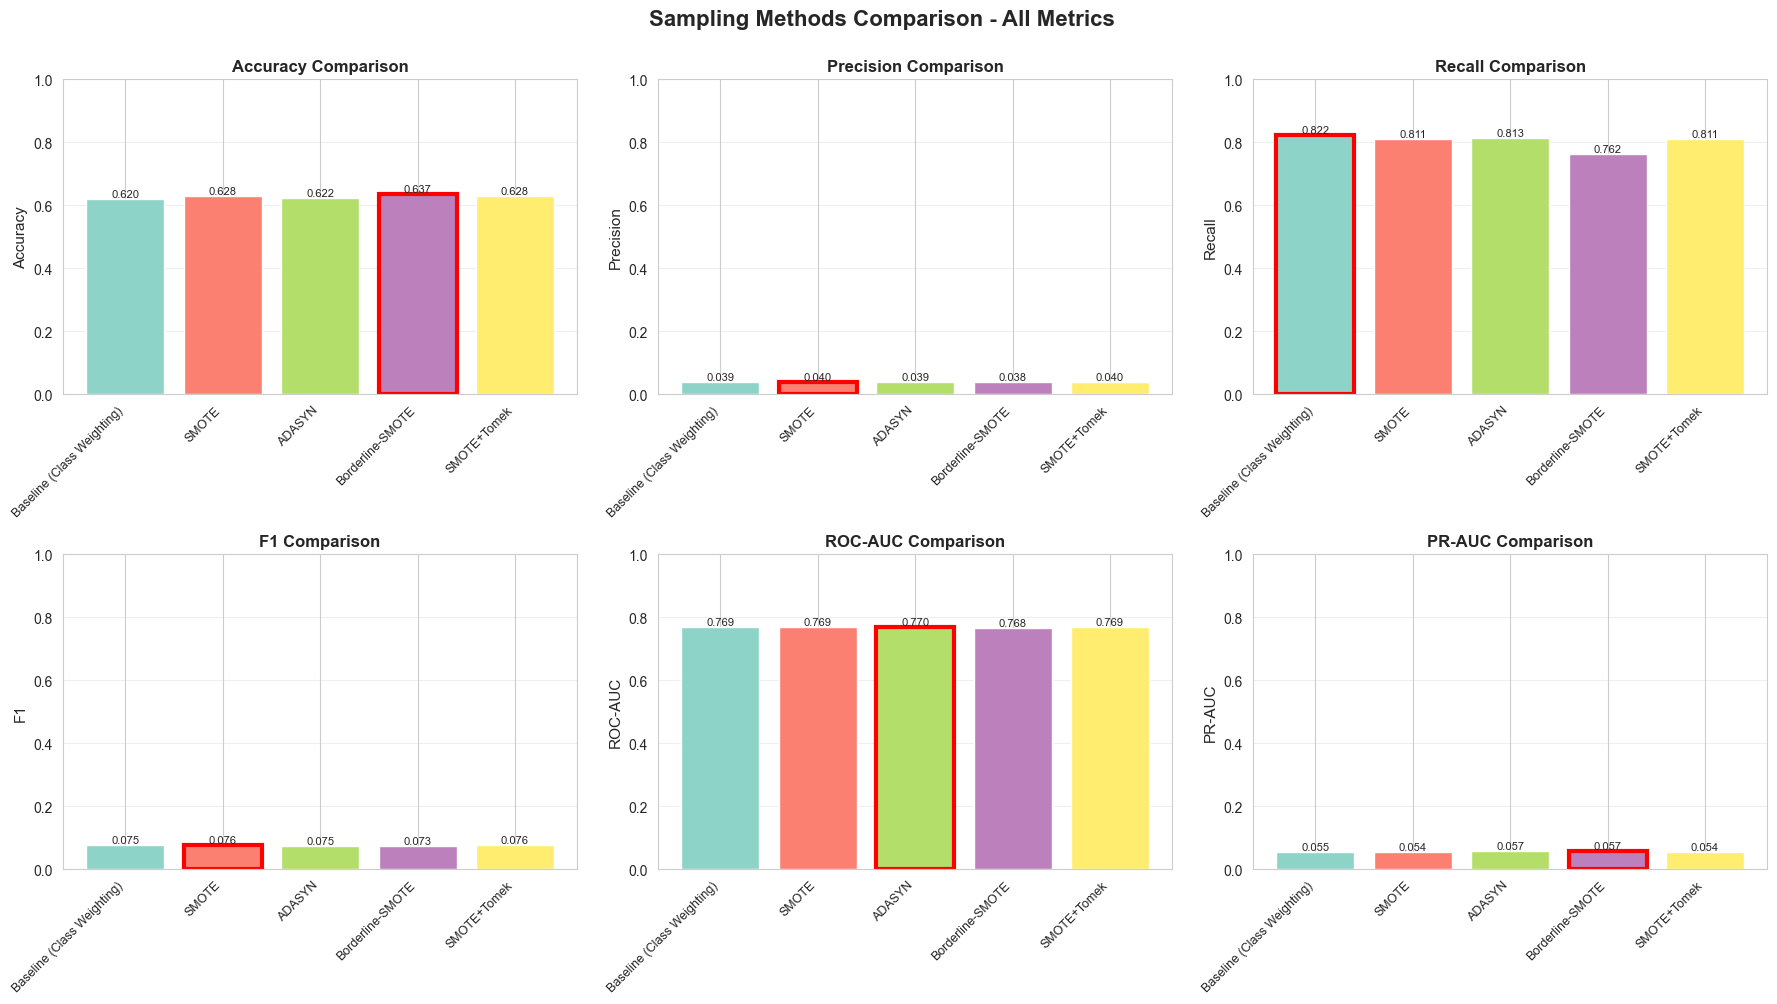

✅ Saved: sampling_methods_comparison.png


In [12]:
# Visualization: Bar chart comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC']
colors = plt.cm.Set3(np.linspace(0, 1, len(comparison_df)))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    values = comparison_df[metric].values
    methods = comparison_df['Method'].values
    
    bars = ax.bar(range(len(methods)), values, color=colors)
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Highlight best performer
    best_idx = values.argmax()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)

plt.suptitle('Sampling Methods Comparison - All Metrics', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(figures_dir / 'sampling_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: sampling_methods_comparison.png")

## 8. Best Method Analysis

In [13]:
# Find best method for each metric
print("BEST METHODS BY METRIC")
print("="*60)

for metric in metrics_to_plot:
    best_idx = comparison_df[metric].idxmax()
    best_method = comparison_df.loc[best_idx, 'Method']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"{metric:12s}: {best_method:20s} ({best_value:.4f})")

# Overall best (based on F1 score)
print("\n" + "="*60)
best_f1_idx = comparison_df['F1'].idxmax()
best_method = comparison_df.loc[best_f1_idx, 'Method']
print(f"\n🏆 OVERALL BEST METHOD (by F1 Score): {best_method}")
print("\nPerformance:")
for metric in metrics_to_plot:
    value = comparison_df.loc[best_f1_idx, metric]
    print(f"  {metric:12s}: {value:.4f}")

BEST METHODS BY METRIC
Accuracy    : Borderline-SMOTE     (0.6371)
Precision   : SMOTE                (0.0397)
Recall      : Baseline (Class Weighting) (0.8224)
F1          : SMOTE                (0.0757)
ROC-AUC     : ADASYN               (0.7700)
PR-AUC      : Borderline-SMOTE     (0.0572)


🏆 OVERALL BEST METHOD (by F1 Score): SMOTE

Performance:
  Accuracy    : 0.6282
  Precision   : 0.0397
  Recall      : 0.8107
  F1          : 0.0757
  ROC-AUC     : 0.7690
  PR-AUC      : 0.0544


## 9. Confusion Matrices Comparison

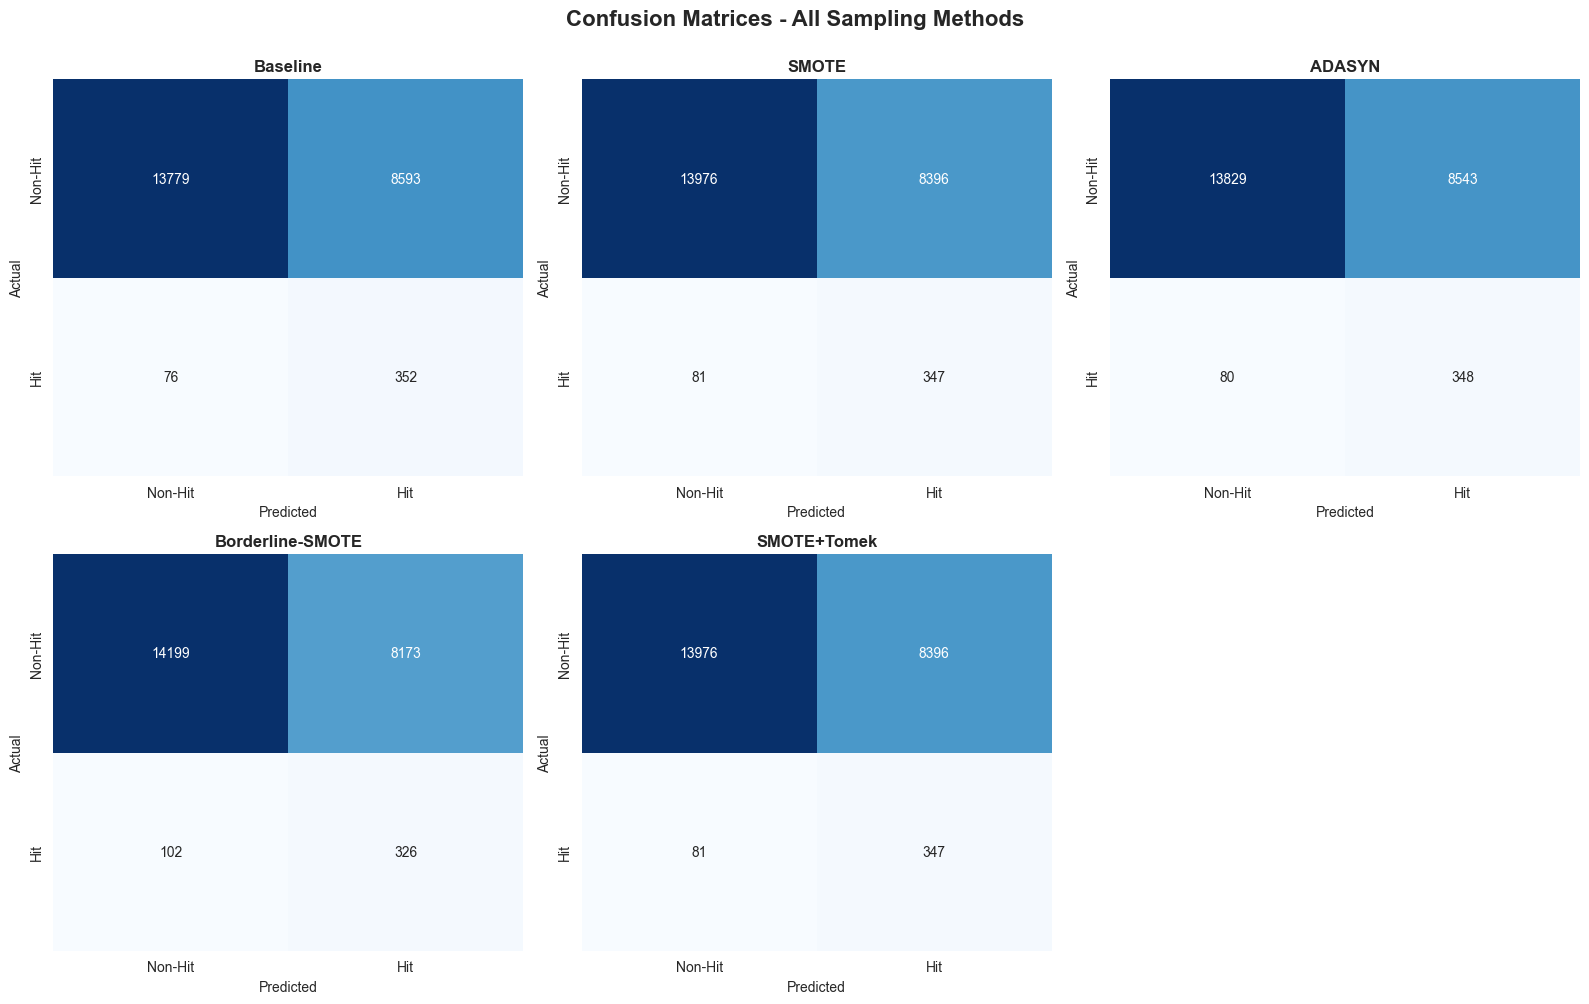

✅ Saved: sampling_confusion_matrices.png


In [14]:
# Plot confusion matrices for all methods
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

predictions = [
    ('Baseline', y_pred_baseline),
    ('SMOTE', y_pred_smote),
    ('ADASYN', y_pred_adasyn),
    ('Borderline-SMOTE', y_pred_bsmote),
    ('SMOTE+Tomek', y_pred_st)
]

for idx, (method, y_pred) in enumerate(predictions):
    ax = axes[idx]
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Hit', 'Hit'],
                yticklabels=['Non-Hit', 'Hit'],
                cbar=False, ax=ax)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{method}', fontweight='bold')

# Hide last subplot
axes[-1].set_visible(False)

plt.suptitle('Confusion Matrices - All Sampling Methods', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(figures_dir / 'sampling_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: sampling_confusion_matrices.png")

## 10. Recommendations

In [15]:
print("="*80)
print("RECOMMENDATIONS")
print("="*80)

# Compare best sampling vs baseline
baseline_f1 = baseline_metrics['F1']
best_f1 = comparison_df['F1'].max()
improvement = ((best_f1 - baseline_f1) / baseline_f1) * 100

print(f"\n1. PERFORMANCE IMPROVEMENT")
print(f"   Baseline F1:     {baseline_f1:.4f}")
print(f"   Best Method F1:  {best_f1:.4f}")
print(f"   Improvement:     {improvement:+.2f}%")

if improvement > 5:
    print(f"\n   ✅ SIGNIFICANT IMPROVEMENT - Use sampling methods!")
elif improvement > 0:
    print(f"\n   ✅ MODEST IMPROVEMENT - Sampling helps but consider trade-offs")
else:
    print(f"\n   ⚠️  NO IMPROVEMENT - Stick with class weighting")

print(f"\n2. METHOD SELECTION GUIDE")
print(f"\n   Use SMOTE when:")
print(f"   • You have severe imbalance (>20:1)")
print(f"   • Small minority class size (<500 samples)")
print(f"   • Data is well-distributed")

print(f"\n   Use ADASYN when:")
print(f"   • Data has varying density")
print(f"   • Some minority samples are harder to learn")
print(f"   • You want adaptive oversampling")

print(f"\n   Use Borderline-SMOTE when:")
print(f"   • Decision boundary is complex")
print(f"   • You want to focus on borderline cases")
print(f"   • More conservative than standard SMOTE")

print(f"\n   Use SMOTE+Tomek when:")
print(f"   • Data has noise/outliers")
print(f"   • Classes overlap significantly")
print(f"   • You want cleaner decision boundaries")

print(f"\n3. TRADE-OFFS")
print(f"\n   Pros of Sampling:")
print(f"   ✅ Often improves recall (catches more hits)")
print(f"   ✅ Balanced training set")
print(f"   ✅ Can help with complex decision boundaries")

print(f"\n   Cons of Sampling:")
print(f"   ❌ Increased training time (more samples)")
print(f"   ❌ Risk of overfitting to synthetic data")
print(f"   ❌ May reduce precision")
print(f"   ❌ Doesn't work well with very high dimensions")

print(f"\n4. FINAL RECOMMENDATION")
if improvement > 5:
    print(f"   🎯 Use {best_method} for production model")
    print(f"   📊 Expected F1 improvement: {improvement:.1f}%")
else:
    print(f"   🎯 Stick with baseline class weighting approach")
    print(f"   📊 Sampling doesn't provide significant benefit")

print("\n" + "="*80)

RECOMMENDATIONS

1. PERFORMANCE IMPROVEMENT
   Baseline F1:     0.0751
   Best Method F1:  0.0757
   Improvement:     +0.75%

   ✅ MODEST IMPROVEMENT - Sampling helps but consider trade-offs

2. METHOD SELECTION GUIDE

   Use SMOTE when:
   • You have severe imbalance (>20:1)
   • Small minority class size (<500 samples)
   • Data is well-distributed

   Use ADASYN when:
   • Data has varying density
   • Some minority samples are harder to learn
   • You want adaptive oversampling

   Use Borderline-SMOTE when:
   • Decision boundary is complex
   • You want to focus on borderline cases
   • More conservative than standard SMOTE

   Use SMOTE+Tomek when:
   • Data has noise/outliers
   • Classes overlap significantly
   • You want cleaner decision boundaries

3. TRADE-OFFS

   Pros of Sampling:
   ✅ Often improves recall (catches more hits)
   ✅ Balanced training set
   ✅ Can help with complex decision boundaries

   Cons of Sampling:
   ❌ Increased training time (more samples)
   ❌ R

## 11. Save Best Model

In [16]:
# Save the best performing model and data
best_idx = comparison_df['F1'].idxmax()
best_method_name = comparison_df.loc[best_idx, 'Method']

# Map to actual model
model_map = {
    'Baseline (Class Weighting)': baseline_model,
    'SMOTE': smote_model,
    'ADASYN': adasyn_model,
    'Borderline-SMOTE': bsmote_model,
    'SMOTE+Tomek': st_model
}

best_model = model_map[best_method_name]

# Save model
joblib.dump(best_model, models_dir / 'best_sampling_model.pkl')
print(f"✅ Saved best model ({best_method_name}) to: {models_dir / 'best_sampling_model.pkl'}")

# Save comparison metrics
comparison_df.to_csv(models_dir / 'sampling_methods_comparison.csv', index=False)
print(f"✅ Saved comparison metrics to: {models_dir / 'sampling_methods_comparison.csv'}")

✅ Saved best model (SMOTE) to: C:\Users\FR33STYLE\FeatureBeats\models\best_sampling_model.pkl
✅ Saved comparison metrics to: C:\Users\FR33STYLE\FeatureBeats\models\sampling_methods_comparison.csv


---

## ✅ Advanced Sampling Complete!

### Key Takeaways:

1. **SMOTE and variants** can help with severe class imbalance
2. **Different methods** excel at different aspects:
   - SMOTE: General purpose, balanced oversampling
   - ADASYN: Adaptive, focuses on hard-to-learn samples
   - Borderline-SMOTE: Conservative, focuses on decision boundary
   - SMOTE+Tomek: Includes cleaning step for noisy data

3. **Trade-offs exist**:
   - Improved recall often comes with reduced precision
   - More training samples = longer training time
   - Risk of overfitting to synthetic data

4. **Not always necessary**:
   - If class weighting works well, stick with it
   - Sampling is most helpful with severe imbalance

### Files Created:
- `figures/sampling_methods_comparison.png`
- `figures/sampling_confusion_matrices.png`
- `models/best_sampling_model.pkl`
- `models/sampling_methods_comparison.csv`

---